### Entire Data Set

#### Import libraries and csv files

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from scipy.stats import mode
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns

sns.color_palette("Set2", 10)
%matplotlib inline

In [2]:
df_aisles = pd.read_csv('aisles.csv')
df_departments = pd.read_csv('departments.csv')
df_order_products_prior = pd.read_csv('order_products__prior.csv')
df_order_products_train = pd.read_csv('order_products__train.csv')
df_orders = pd.read_csv('orders.csv')
df_products = pd.read_csv('products.csv')

### Build dataframe with Features and Target

In [3]:
# add detailed order info to train and prior order products df's

df_order_products_train = df_order_products_train.merge(df_orders.drop('eval_set', axis=1), on='order_id')
df_order_products_prior = df_order_products_prior.merge(df_orders.drop('eval_set', axis=1), on='order_id')

# get unique user-product combinations and sum associated order id's to get total count
# of each time that user-product combination occured, meaning total times the user ordered that product
# use prior data b/c we're getting user order history (not current/last cart)

df_user_product = (df_order_products_prior.groupby(['product_id','user_id'],as_index=False) 
                                          .agg({'order_id':'count'}) 
                                          .rename(columns={'order_id':'user_product_total_orders'}))

# now get the user id's from prior that appear in train
# we need to know the status of our train users' current/latest cart in order to populate the target train set

train_ids = df_order_products_train['user_id'].unique() 
df_X = df_user_product[df_user_product['user_id'].isin(train_ids)]


# now we want to add some user information as a predictive feature
# get list of items in the user's current cart, which we can use to determine 
# whether a previously ordered item is in the user's current cart

# use train (current) data and groupby user_id, then aggregate unique product id's 
# means we lose duplicates in current cart, but doesn't matter b/c we already know how many times
# that user has ordered that product
# product_id column is now a list of product ids representing the current (latest) cart

train_carts = (df_order_products_train.groupby('user_id',as_index=False)
                                      .agg({'product_id':(lambda x: set(x))})
                                      .rename(columns={'product_id':'latest_cart'}))

# now we'll add that current/latest cart to our model inputs df

df_X = df_X.merge(train_carts, on='user_id')

# add new column 'in_cart' representing whether a product the user has previously ordered is now in their current cart
# 'in_cart' column is our target that we want to predict
# this new df contains info from both prior and train df's
# this new df is the df that we will split into train and test, since it now contains both past and current cart info

df_X['in_cart'] = (df_X.apply(lambda row: row['product_id'] in row['latest_cart'], axis=1).astype(int))

df_X.head()

,product_id,user_id,user_product_total_orders,latest_cart,in_cart
0,1,138,2,{42475},0
1,907,138,2,{42475},0
2,1000,138,1,{42475},0
3,3265,138,1,{42475},0
4,4913,138,1,{42475},0


#### Check Target Distribution

In [4]:
df_X.in_cart.value_counts(normalize=True)

0    0.9022
1    0.0978
Name: in_cart, dtype: float64

In [6]:
df_X.in_cart.value_counts()

0    7645837
1     828824
Name: in_cart, dtype: int64

In [5]:
num_reorders = df_X[df_X['in_cart'] == 1].shape[0]
num_not_reordered = df_X[df_X['in_cart'] == 0].shape[0]
print(num_reorders, num_not_reordered)

828824 7645837


Text(0,0.5,'Ordered Products')

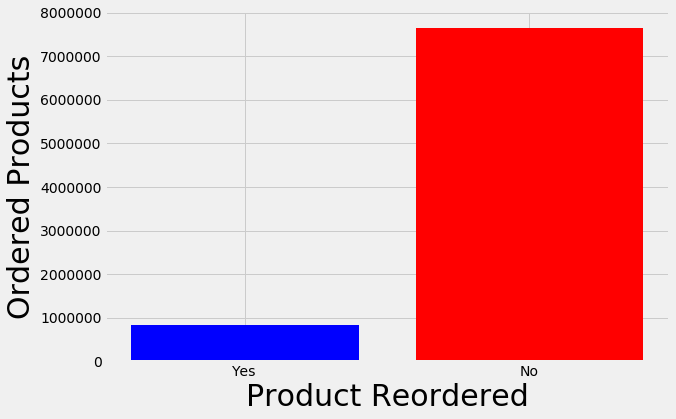

In [41]:

reorder_vals = [num_reorders, num_not_reordered]

plt.figure(figsize=(9,6))
plt.style.use('fivethirtyeight')
plt.bar([1,2], reorder_vals, color=['b','r'])
plt.xlabel('Product Reordered', fontsize=30)
plt.xticks([1,2],['Yes','No'])
plt.ylabel('Ordered Products', fontsize=30)
#plt.title('Reorder Distribution');

### Feature Engineering

#### Product Features

In [11]:
# let's build some new features out of this information
# how many times has each product been ordered? 
    # --> number of unique orders for each product id
# in what order is each product typically added to the cart? do certain products tend to be first or last?
    # --> mean of add to cart order for each product id
    
prod_features = ['product_total_orders','product_avg_add_to_cart_order']

df_prod_features = (df_order_products_prior.groupby(['product_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'),
                                                    ('add_to_cart_order','mean')])))
df_prod_features.columns = ['product_id'] + prod_features

df_X.isnull().sum()

# add our new features to our training set

df_X = df_X.merge(df_prod_features, on='product_id')


In [22]:
top_products = df_X.drop(['user_id','latest_cart'], axis=1).merge(df_products,on='product_id')
top_products = top_products.groupby(['product_id','product_name'],as_index=False).agg('product_total_orders').sum()
df_top_products = top_products.sort_values(by='product_total_orders', ascending=False)
df_top_products.head(20)

,product_id,product_name,product_total_orders
24760,24852,Banana,22193542660
13118,13176,Bag of Organic Bananas,15365068850
21055,21137,Organic Strawberries,9917142644
21819,21903,Organic Baby Spinach,8490701337
47004,47209,Organic Hass Avocado,5928237504
47559,47766,Organic Avocado,4824397275
47419,47626,Large Lemon,4504908070
26108,26209,Limes,4025025994
16731,16797,Strawberries,3927149872
27851,27966,Organic Raspberries,2767866115


#### User Features

In [23]:
user_features = ['user_total_orders','user_avg_cartsize','user_total_products','user_avg_days_since_prior_order']

df_user_features = (df_order_products_prior.groupby(['user_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id',['nunique', (lambda x: x.shape[0] / x.nunique())]),
                                                    ('product_id','nunique'),
                                                    ('days_since_prior_order','mean')])))

df_user_features.columns = ['user_id'] + user_features

df_X = df_X.merge(df_user_features, on='user_id')
df_X.isnull().sum()

product_id                         0
user_id                            0
user_product_total_orders          0
latest_cart                        0
in_cart                            0
product_total_orders               0
product_avg_add_to_cart_order      0
user_total_orders                  0
user_avg_cartsize                  0
user_total_products                0
user_avg_days_since_prior_order    0
dtype: int64

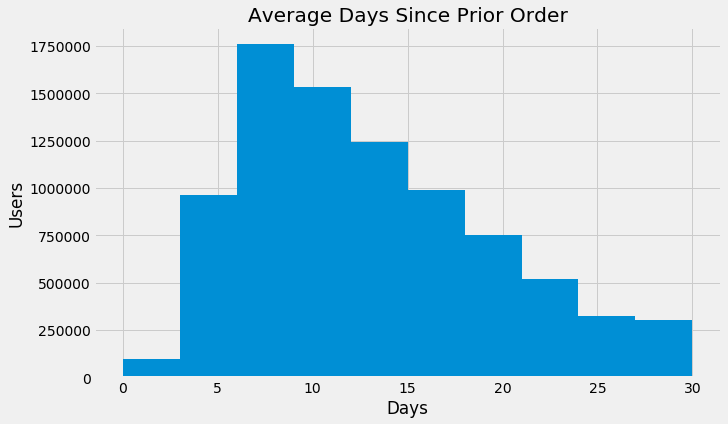

In [26]:
# plot
plt.figure(figsize=(10,6))
plt.hist(df_X['user_avg_days_since_prior_order'])
plt.xlabel('Days')
plt.ylabel('Users')
plt.title('Average Days Since Prior Order')
plt.show();

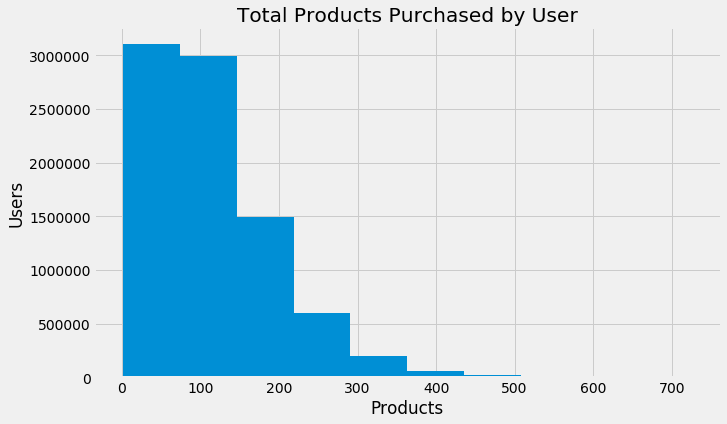

In [28]:
#plot
plt.figure(figsize=(10,6))
plt.hist(df_X['user_total_products'])
plt.xlabel('Products')
plt.ylabel('Users')
plt.title('Total Products Purchased by User')
plt.show();


#### User-Product Features

In [29]:
user_prod_features = ['user_product_avg_add_to_cart_order']

df_user_prod_features = (df_order_products_prior.groupby(['product_id','user_id'],as_index=False) \
                                                .agg(OrderedDict(
                                                     [('add_to_cart_order','mean')])))

df_user_prod_features.columns = ['product_id','user_id'] + user_prod_features 

df_X = df_X.merge(df_user_prod_features,on=['user_id','product_id']) # adding user_product_avg_add_to_cart_order

# how often does each user order each product?

df_X['user_product_order_freq'] = df_X['user_product_total_orders'] / df_X['user_total_orders'] 

#### Aisle & Department Features

In [30]:
# let's try adding product category / aisle information as categorical features

# combine aisle and department info with product info

df_products = df_products.merge(df_aisles, on='aisle_id')
df_products = df_products.merge(df_departments, on='department_id')

aisle_counts = df_products['aisle'].value_counts()
# first row: 1258 missing
# start with top 20; later test top 40
aisles_top_20 = aisle_counts[1:21]
aisles_other = aisle_counts[21:]

df_top_aisles = df_products
df_top_aisles['aisle'] = [name if name in aisles_top_20 else 'other' for name in df_products['aisle']]

df_X = df_X.merge(df_top_aisles,on=['product_id'])

df_dummy_aisles = pd.get_dummies(df_X['aisle'], prefix='aisle')
df_dummy_departments = pd.get_dummies(df_X['department'], prefix='dept')
df_dummy_aisledepts = pd.concat([df_dummy_aisles, df_dummy_departments], axis=1)
df_X = pd.concat([df_X, df_dummy_aisledepts], axis=1)

#### Features Built on Ordering Patterns

In [31]:
# how many orders has it been since user last ordered this product?


df_user_prod_priororder = (df_order_products_prior.groupby(['product_id','user_id'],as_index=False) 
                                          .agg({'order_number':'max'}) 
                                          .rename(columns={'order_number':'prior_user_product_last_order'}))

df_user_prod_trainorder = (df_order_products_train.groupby('user_id',as_index=False)
                                                  .agg('order_number').max()
                                                  .rename(columns={'order_number':'train_user_order_number'}))

df_user_prod_trainorder = (df_user_prod_trainorder
                           .merge(df_user_prod_priororder, on='user_id', how='right'))

#df_user_prod_trainorder = (df_user_prod_trainorder.groupby('user_id',as_index=False)
                                                  #.agg({['order_number','prior_user_product_last_order']
                                                       # :(lambda x,y: x-y)}))
                                                  #.agg(diff b/w order_number and prior)


df_user_prod_trainorder['user_orders_since_product'] = (df_user_prod_trainorder['train_user_order_number']
                                                        - df_user_prod_trainorder['prior_user_product_last_order'])

df_X = df_X.merge(df_user_prod_trainorder, on=['user_id','product_id'],how='left')

#### 5 Order Frequency

In [32]:
# get user max (most recent) order number from train
# merge into prior order history

user_max_ordernum = (df_order_products_train.groupby('user_id',as_index=False)
                                                  .agg('order_number').max()
                                                  .rename(columns={'order_number':'user_max_order_num'}))

df_user_all_orders = (df_order_products_prior.drop(['add_to_cart_order','reordered','order_dow',
                                                       'order_hour_of_day'],axis=1)
                                                .merge(user_max_ordernum, on='user_id')
                                                .rename(columns={'order_number':'prior_order_num'}))

# isolate earliest prior orders (least relevant)
df_user_all_orders[df_user_all_orders['prior_order_num'] <= 5].head(3)

# grab users' previous 5 orders 
# where difference between max order num and prior order num <=5 

df_user_recent_orders = (df_user_all_orders[df_user_all_orders['user_max_order_num'] 
                                               - df_user_all_orders['prior_order_num'] <= 5])

# number of unique orders (recent) per user (will be <=5)

user_orders_recent = (df_user_recent_orders.groupby(['user_id'],as_index=False)
                                           .agg({'order_id':'nunique'})
                                           .rename(columns={'order_id':'user_orders_recent'}))

# among those recent orders, how many included each product?  

user_product_orders_recent = (df_user_recent_orders.groupby(['user_id','product_id'],as_index=False)
                                           .agg({'order_id':'nunique'})
                                           .rename(columns={'order_id':'user_prod_orders_recent'}))

# merge recent user order counts with recent user product order counts so we can calculate frequency

df_user_product_orders_recent = user_product_orders_recent.merge(user_orders_recent,on='user_id')

df_user_product_orders_recent['five_order_freq'] = (df_user_product_orders_recent['user_prod_orders_recent'] /
                                                    df_user_product_orders_recent['user_orders_recent'])

# add five_order_freq to df_X 

df_X = (df_X.merge(df_user_product_orders_recent.drop(['user_prod_orders_recent','user_orders_recent'],axis=1),
                   on=['user_id','product_id']))

### 3 Order Frequency

In [33]:
# grab users' previous 3 orders 
# where difference between max order num and prior order num <=3 

df_user_recent_orders = (df_user_all_orders[df_user_all_orders['user_max_order_num'] 
                                               - df_user_all_orders['prior_order_num'] <= 3])

# number of unique orders (recent) per user (will be <=3)

user_orders_recent = (df_user_recent_orders.groupby(['user_id'],as_index=False)
                                             .agg({'order_id':'nunique'})
                                             .rename(columns={'order_id':'user_orders_recent'}))


# among those recent orders, how many included each product?  

user_product_orders_recent = (df_user_recent_orders.groupby(['user_id','product_id'],as_index=False)
                                           .agg({'order_id':'nunique'})
                                           .rename(columns={'order_id':'user_prod_orders_recent'}))

# merge recent user order counts with recent user product order counts so we can calculate frequency

df_user_product_orders_recent = user_product_orders_recent.merge(user_orders_recent,on='user_id')

df_user_product_orders_recent['three_order_freq'] = (df_user_product_orders_recent['user_prod_orders_recent'] /
                                                    df_user_product_orders_recent['user_orders_recent'])

# add three_order_freq to df_X 

df_X = (df_X.merge(df_user_product_orders_recent.drop(['user_prod_orders_recent','user_orders_recent'],axis=1),
                   on=['user_id','product_id']))

#### 7 Order Frequency

In [35]:
#  7 Order Frequency

# grab users' previous 3 orders 
# where difference between max order num and prior order num <=3 

df_user_recent_orders = (df_user_all_orders[df_user_all_orders['user_max_order_num'] 
                                               - df_user_all_orders['prior_order_num'] <= 7])

# number of unique orders (recent) per user (will be <=3)

user_orders_recent = (df_user_recent_orders.groupby(['user_id'],as_index=False)
                                             .agg({'order_id':'nunique'})
                                             .rename(columns={'order_id':'user_orders_recent'}))


# among those recent orders, how many included each product?  

user_product_orders_recent = (df_user_recent_orders.groupby(['user_id','product_id'],as_index=False)
                                           .agg({'order_id':'nunique'})
                                           .rename(columns={'order_id':'user_prod_orders_recent'}))

# merge recent user order counts with recent user product order counts so we can calculate frequency

df_user_product_orders_recent = user_product_orders_recent.merge(user_orders_recent,on='user_id')

df_user_product_orders_recent['seven_order_freq'] = (df_user_product_orders_recent['user_prod_orders_recent'] /
                                                    df_user_product_orders_recent['user_orders_recent'])

# add three_order_freq to df_X 

# ADD THIS LINE BACK
#df_X = (df_X.merge(df_user_product_orders_recent.drop(['user_prod_orders_recent','user_orders_recent'],axis=1),
                   #on=['user_id','product_id']))

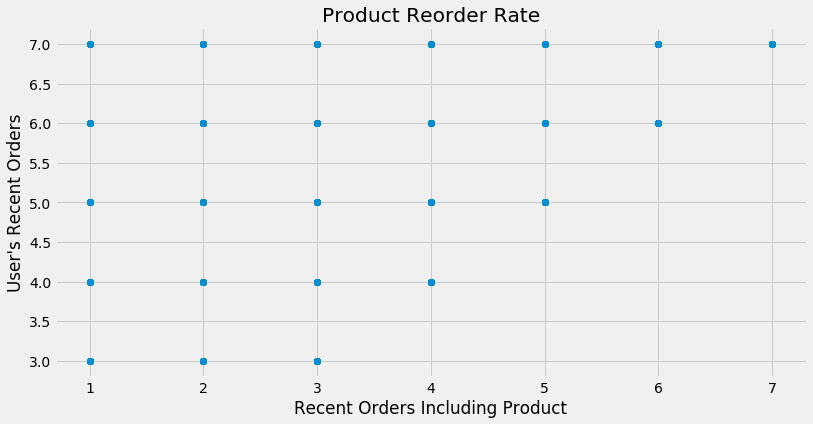

In [37]:
recent_product_orders = df_user_product_orders_recent['user_prod_orders_recent']
recent_orders = df_user_product_orders_recent['user_orders_recent']
# scatter add jitter
plt.figure(figsize=(12,6))
plt.scatter(recent_product_orders, recent_orders)
plt.ylabel("User's Recent Orders")
plt.xlabel("Recent Orders Including Product")
plt.title("Product Reorder Rate")
plt.show();

In [17]:
# total recent product orders as a percentage of total recent orders 


df_user_recent_orders = (df_user_all_orders[df_user_all_orders['user_max_order_num'] 
                                               - df_user_all_orders['prior_order_num'] <= 5])
    
total_recent_orders = len(df_user_recent_orders['order_id'].unique())


                    
df_prod_features = (df_user_recent_orders.groupby(['product_id'],as_index=False)
                                           .agg(OrderedDict([('order_id','nunique')]))
                                           .rename(columns={'order_id':'product_recent_orders'}))
                    

df_prod_features['product_recent_freq'] = df_prod_features['product_recent_orders'] / total_recent_orders

df_X = df_X.merge(df_prod_features.drop('product_recent_orders',axis=1),on='product_id')

#### Day of Week

In [20]:
# get mode day of week for each user_product

f = lambda x: mode(x, axis=None)[0][0]
dow_mode_count = df_order_products_prior.groupby(['user_id','product_id'])['order_dow'].apply(f)

df_dow_mode = dow_mode_count.to_frame('dow_mode').reset_index()

df_prior_dow_mode = df_order_products_prior.merge(df_dow_mode, on=['user_id','product_id'])

df_prior_dow_mode['day_mode_diff'] = df_prior_dow_mode['dow_mode'] - df_prior_dow_mode['order_dow']

df_dow_to_merge = df_prior_dow_mode.drop(['order_id','add_to_cart_order','reordered','order_number','order_dow',
                                           'order_hour_of_day','days_since_prior_order','dow_mode'],axis=1)

df_X = (df_X.merge(df_dow_to_merge,on=['product_id','user_id']))

### Save to CSV

In [21]:
df_X.columns

Index(['product_id', 'user_id', 'user_product_total_orders', 'latest_cart',
       'in_cart', 'product_total_orders', 'product_avg_add_to_cart_order',
       'user_total_orders', 'user_avg_cartsize', 'user_total_products',
       'user_avg_days_since_prior_order', 'user_product_avg_add_to_cart_order',
       'user_product_order_freq', 'product_name', 'aisle_id', 'department_id',
       'aisle', 'department', 'aisle_baby food formula',
       'aisle_baking ingredients', 'aisle_candy chocolate',
       'aisle_chips pretzels', 'aisle_cleaning products', 'aisle_coffee',
       'aisle_cookies cakes', 'aisle_crackers', 'aisle_energy granola bars',
       'aisle_frozen meals', 'aisle_hair care', 'aisle_ice cream ice',
       'aisle_juice nectars', 'aisle_other', 'aisle_packaged cheese',
       'aisle_refrigerated', 'aisle_soup broth bouillon',
       'aisle_spices seasonings', 'aisle_tea', 'aisle_vitamins supplements',
       'aisle_yogurt', 'dept_alcohol', 'dept_babies', 'dept_bakery',
     

In [22]:
df_X.to_csv('InstacartAllData.csv')

In [ ]:
# sklearn hack:
# n_jobs = -1 to use all available cores